In [1]:
import osmnx as ox
import geopandas as gpd
from neo4j import GraphDatabase
import networkx as nx 


C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1892144417.py:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_place(place_name, tags={'amenity': 'pharmacy'})


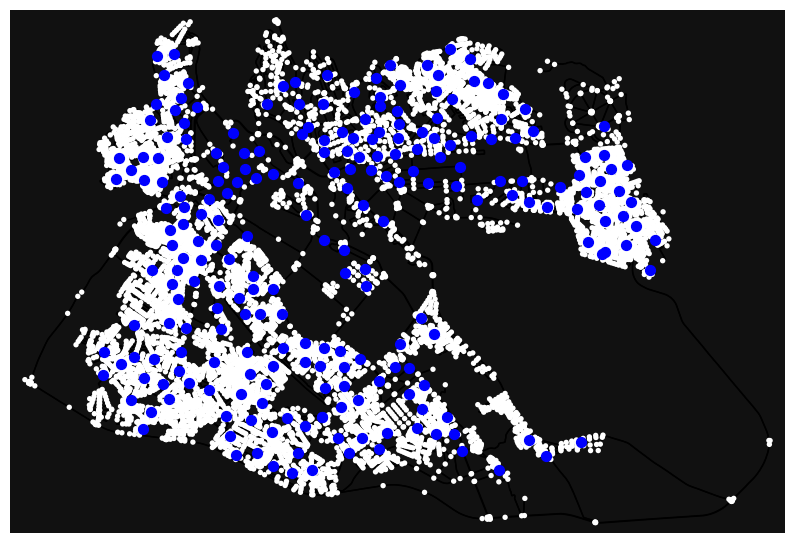

In [13]:
# Spécifiez le nom de l'endroit
place_name = "Meknes, Morocco"

# Télécharger les données du graphe de la ville de Meknes, Maroc
graph = ox.graph_from_place(place_name, network_type="drive")

# Extraire tous les points d'intérêt (POI) de la ville de Meknes pour les pharmacies
pois = ox.geometries_from_place(place_name, tags={'amenity': 'pharmacy'})

# Filtrer les géométries pour ne conserver que celles de type Point
pharmacies_gdf = gpd.GeoDataFrame(pois[pois.geometry.type == 'Point'])

# Afficher la carte de Meknes
fig, ax = ox.plot_graph(graph, figsize=(10, 10), show=False, close=False, edge_color='k', node_color='w')
ax.scatter(pharmacies_gdf['geometry'].x, pharmacies_gdf['geometry'].y, color='blue', s=50, label='Pharmacies')



In [14]:
# Afficher les noms des pharmacies sous forme de liste
print("Liste des pharmacies à Meknes, Maroc:")
for pharmacies_name in pharmacies_gdf['name'].unique():
    print("- ", pharmacies_name)

Liste des pharmacies à Meknes, Maroc:
-  Pharmacie Bounoua صيدلية بونوا
-  Pharmacie Al Watanya الصيدلية الوطنية
-  Pharmacie Riad Salam صيدلية رياض السلام
-  Pharmacie Diour Salam صيدلية ديور السلام
-  Pharmacie Saada صيدلية السعادة
-  Pharmacie Moulay Meliana صيدلية مولاي مليانة
-  Pharmacie Annasr صيدلية النصر
-  Pharmacie Ibn Rochd صيدلية بن رشد
-  Pharmacie Faris صيدلية فارس
-  Pharmacie Zahir صيدلية زاهير
-  Pharmacie Nouvelle الصيدلية الجديدة
-  Pharmacie Hay Assalam صيدلية حي السلام
-  Pharmacie Injad صيدلية إنجاد
-  Pharmacie Chorfas صيدلية الشرفاء
-  Pharmacie Cheikh El Kamel صيدلية الشيخ الكامل
-  Pharmacie Bab Rha صيدلية باب الرحى
-  Pharmacie Rond Point Caméra صيدلية مدار كاميرا
-  Pharmacie Bab Khemis صيدلية باب الخميس
-  Pharmacie de l'Atlas صيدلية الأطلس
-  Pharmacie la Liberté صيدلية الحرية
-  Pharmacie Al Afaq صيدلية الاًفاق
-  Pharmacie Jamaa Soussi صيدلية جامع السوسي
-  Pharmacie Ibn Sina صيدلية ابن سينا
-  Pharmacie Riad Meknès صيدلية رياض مكناس
-  Pharmacie Zitoun

# Insertion des Pharmacies dans Neo4j

In [15]:
# Fonction pour établir une connexion à la base de données Neo4j
def connect_to_neo4j(uri, user, password):
    return GraphDatabase.driver(uri, auth=(user, password))

# Spécifiez les informations de connexion à votre base de données Neo4j
uri = "bolt://localhost:7687"
user = "neo4j"
password = "password"

# Établissez une connexion à la base de données Neo4j
driver = connect_to_neo4j(uri, user, password)


C:\Users\HP\anaconda3\lib\site-packages\neo4j\_sync\driver.py:513: ResourceWarning: unclosed  BoltDriver: <neo4j._sync.driver.BoltDriver object at 0x00000223A4AB1450>.
  _unclosed_resource_warn(self)
C:\Users\HP\anaconda3\lib\site-packages\neo4j\_sync\driver.py:518: DeprecationWarning: Relying on Driver's destructor to close the session is deprecated. Please make sure to close the session. Use it as a context (`with` statement) or make sure to call `.close()` explicitly. Future versions of the driver will not close drivers automatically.
  _deprecation_warn(
Failed to write data to connection IPv4Address(('localhost', 7687)) (ResolvedIPv4Address(('127.0.0.1', 7687)))


In [16]:
def insert_pharmacies_to_neo4j(pharmacies_gdf):
    with driver.session() as session:
        # Supprimez d'abord toutes les pharmacies existantes
        session.run("MATCH (p:Pharmacie) DETACH DELETE p")
        
        # Insérez les nouvelles pharmacies
        for idx, row in pharmacies_gdf.iterrows():
            cypher_query = (
                "CREATE (p:Pharmacie {id: $id, name: $name, latitude: $latitude, longitude: $longitude})"
            )
            session.run(cypher_query, id=str(idx), name=row.get('name', 'unknown'), latitude=row['geometry'].y, longitude=row['geometry'].x)

# Utilisation de la fonction pour insérer les pharmacies et la localisation dans Neo4j
insert_pharmacies_to_neo4j(pharmacies_gdf)

print("Les données des pharmacies ont été insérées dans Neo4j avec succès.")

Les données des pharmacies ont été insérées dans Neo4j avec succès.


In [17]:
import geocoder

def get_current_location():
    # Utilisez la fonction ip() pour obtenir l'emplacement basé sur votre adresse IP
    location = geocoder.ip('me')
    return location.latlng  # Renvoie une liste contenant la latitude et la longitude

current_location = get_current_location()
if current_location:
    latitude, longitude = current_location

latitude, longitude

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1415593688.py:8: ResourceWarning: unclosed <socket.socket fd=3936, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.147', 55185), raddr=('34.117.186.192', 80)>
  current_location = get_current_location()


(33.8935, -5.5473)

In [18]:
def insert_location_to_neo4j(current_location):
    with driver.session() as session:
        # Supprimez d'abord tous les emplacements existants
        session.run("MATCH (l:Location) DETACH DELETE l")
        # Insérez la localisation dans la base de données
        session.run("CREATE (l:Location {latitude: $latitude, longitude: $longitude})", 
                    latitude=current_location['latitude'], longitude=current_location['longitude'])

# Exemple de localisation actuelle
current_location = {"latitude": latitude, "longitude": longitude}

# Utilisation de la fonction pour insérer la localisation dans Neo4j
insert_location_to_neo4j(current_location)

print("La localisation a été insérée dans Neo4j avec succès.")

La localisation a été insérée dans Neo4j avec succès.


In [19]:
def insert_roads_between_pharmacies(graph, pharmacies_gdf):
    with driver.session() as session:
        for idx, row in pharmacies_gdf.iterrows():
            pharmacy_name = row.get('name', f'Pharmacy_{idx}')
            pharmacy_point = (row['geometry'].y, row['geometry'].x)
            # Trouver le nœud OSM le plus proche de la pharmacie
            nearest_node = ox.distance.nearest_nodes(graph, X=row['geometry'].x, Y=row['geometry'].y)
            # Trouver les autres pharmacies et les connecter via les routes
            for other_idx, other_row in pharmacies_gdf.iterrows():
                if other_idx != idx:
                    other_pharmacy_name = other_row.get('name', f'Pharmacy_{other_idx}')
                    other_pharmacy_point = (other_row['geometry'].y, other_row['geometry'].x)
                    nearest_other_node = ox.distance.nearest_nodes(graph, X=other_row['geometry'].x, Y=other_row['geometry'].y)
                    # Calculer le plus court chemin entre les deux nœuds
                    shortest_path = nx.shortest_path(graph, nearest_node, nearest_other_node, weight='length')
                    if shortest_path:
                        # Calculer la distance du chemin
                        distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
                        # Créer une relation entre les pharmacies
                        session.run(
                            "MATCH (p1:Pharmacie {name: $pharmacy_name}), (p2:Pharmacie {name: $other_pharmacy_name}) "
                            "CREATE (p1)-[:CONNECTED_BY_ROAD {distance: $distance}]->(p2)",
                            pharmacy_name=pharmacy_name,
                            other_pharmacy_name=other_pharmacy_name,
                            distance=distance
                        )

# Insérez les relations de routes entre les pharmacies dans Neo4j
insert_roads_between_pharmacies(graph, pharmacies_gdf)

print("Les routes entre les pharmacies ont été insérées dans Neo4j avec succès.")

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `routing.route_to_gdf` function instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  distance = sum(ox.utils_graph.get_route_edge_attributes(graph, shortest_path, 'length'))
C:\Users\HP\AppData\Local\Temp\ipykernel_23648\1812819577.py:18: FutureWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in the v2.0.0 release. Use the `r

DatabaseError: {code: Neo.DatabaseError.Transaction.TransactionLogError} {message: Could not append transaction: Transaction #20697 {started 2024-05-27 19:52:19.395+0000, committed 2024-05-27 19:52:19.395+0000, with 14 commands in this transaction, lease -1, latest committed transaction id when started was 20696, consensusIndex: -1} to log.}